# Try a GAN on MNIST

In [1]:
%matplotlib inline
#Import a ton of stuff
import os
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from keras.utils.generic_utils import Progbar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Using Theano backend.
Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:01:00.0)


In [2]:
# Load the MNIST CSV data from https://pjreddie.com/projects/mnist-in-csv/
data_train = np.genfromtxt('./MNIST_Data/mnist_train.csv', delimiter = ',').astype(np.uint8)
data_test = np.genfromtxt('./MNIST_Data/mnist_test.csv', delimiter = ',').astype(np.uint8)
print(data_train.shape, data_test.shape)

(60000, 785) (10000, 785)


In [3]:
# Now reformat it into the format we want
# NOTE: PyTorch is weird so if we wanted to use cross entropy we need to keep them as logits, but we won't so...
x_train = np.reshape(data_train[:, 1:], (-1, 1, 28, 28))
#y_train = data_train[:, 0]
y_train = np.zeros((data_train.shape[0], 10), dtype = np.uint8)
y_train[np.arange(data_train.shape[0]), data_train[:, 0].astype(int)] = 1

x_test = np.reshape(data_test[:, 1:], (-1, 1, 28, 28))
#y_test = data_test[:, 0]
y_test = np.zeros((data_test.shape[0], 10), dtype = np.uint8)
y_test[np.arange(data_test.shape[0]), data_test[:, 0].astype(int)] = 1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Looks like we can convert our x to unint8
# We'll convert back to float and rescale to between 0 and 1 on the GPU batchwise to save CPU RAM
print(np.unique(x_train))
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 2

[0 0 0 0 0 0 0 1 0 0]


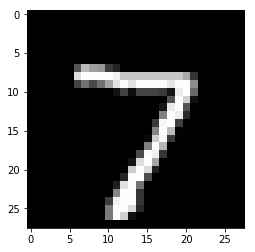

In [4]:
# Show an example from the test set
print(y_test[0])
plt.figure(0)
plt.imshow(x_test[0, 0], cmap = 'gray')

In [5]:
# Now let's start building the GAN
# But first, we're going to redefine Conv2D and Linear with our own initialisations
# We're going to use Glorot (aka Xavier) uniform init for all weights
# And we will use zero init for all biases
class Conv2d(nn.Conv2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Linear(nn.Linear):
    def reset_parameters(self):
        stdv = np.sqrt(6 / (self.in_features + self.out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = Linear(128, 256)
        self.fc2 = Linear(256, 512)

        self.conv1 = Conv2d(2, 16, kernel_size = 5, padding = 2) # 2 x 16 x 16 -> 16 x 32 x 32
        self.conv2 = Conv2d(16, 1, kernel_size = 5) # 32 x 32 x 32 -> 1 x 28 x 28

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x)).view(-1, 2, 16, 16)

        x = F.upsample(x, scale_factor = 2, mode = 'nearest')
        x = F.elu(self.conv1(x))

        return F.sigmoid(self.conv2(x))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = Conv2d(1, 16, kernel_size = 5) # 1 x 28 x 28 -> 16 x 12 x 12
        self.conv2 = Conv2d(16, 32, kernel_size = 5) # 16 x 12 x 12 -> 32 x 4 x 4

        self.fc1 = Linear(512, 256)
        self.fc2 = Linear(256, 1)

    def forward(self, x):
        x = F.max_pool2d(F.elu(self.conv1(x)), 2)
        x = F.max_pool2d(F.elu(self.conv2(x)), 2).view(-1, 512)

        hid = F.elu(self.fc1(x))
        out = self.fc2(hid)
        return out, hid

In [6]:
# OK, now we create the actual models
gen = Generator().cuda()
dis = Discriminator().cuda()

In [7]:
# Prep the data by turning them into tensors and putting them into a PyTorch dataloader
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
train_tensors = TensorDataset(x_train, y_train)
test_tensors = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(test_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)

In [8]:
# Create the optimisers
g_optim = optim.Adam(gen.parameters(), lr=1e-4)
d_optim = optim.Adam(dis.parameters(), lr=1e-4)

Start training
Epoch  1
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.0998 - loss_gen: 0.8319
Epoch  2
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2042 - loss_gen: 0.6424
Epoch  3
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.1896 - loss_gen: 0.6759
Epoch  4
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.1872 - loss_gen: 0.6547
Epoch  5
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2057 - loss_gen: 0.7022
Epoch  6
59776/60000 [============================>.] - ETA: 0s - loss_dis: 0.2090 - loss_gen: 0.6497
Epoch  7
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2195 - loss_gen: 0.6417
Epoch  8
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2099 - loss_gen: 0.6408
Epoch  9
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2378 - loss_gen: 0.5947
Epoch  10
45024/60000 [=====================>........] - ETA: 3s - 

45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2096 - loss_gen: 0.6830
Epoch  81
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2054 - loss_gen: 0.6482
Epoch  82
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2143 - loss_gen: 0.6548
Epoch  83
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2144 - loss_gen: 0.6577
Epoch  84
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2172 - loss_gen: 0.6852
Epoch  85
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2170 - loss_gen: 0.6624
Epoch  86
59776/60000 [============================>.] - ETA: 0s - loss_dis: 0.2142 - loss_gen: 0.6583
Epoch  87
59904/60000 [============================>.] - ETA: 0s - loss_dis: 0.2141 - loss_gen: 0.6576
Epoch  88
59776/60000 [============================>.] - ETA: 0s - loss_dis: 0.2145 - loss_gen: 0.6587
Epoch  89
45024/60000 [=====================>........] - ETA: 3s - loss_dis: 0.2050

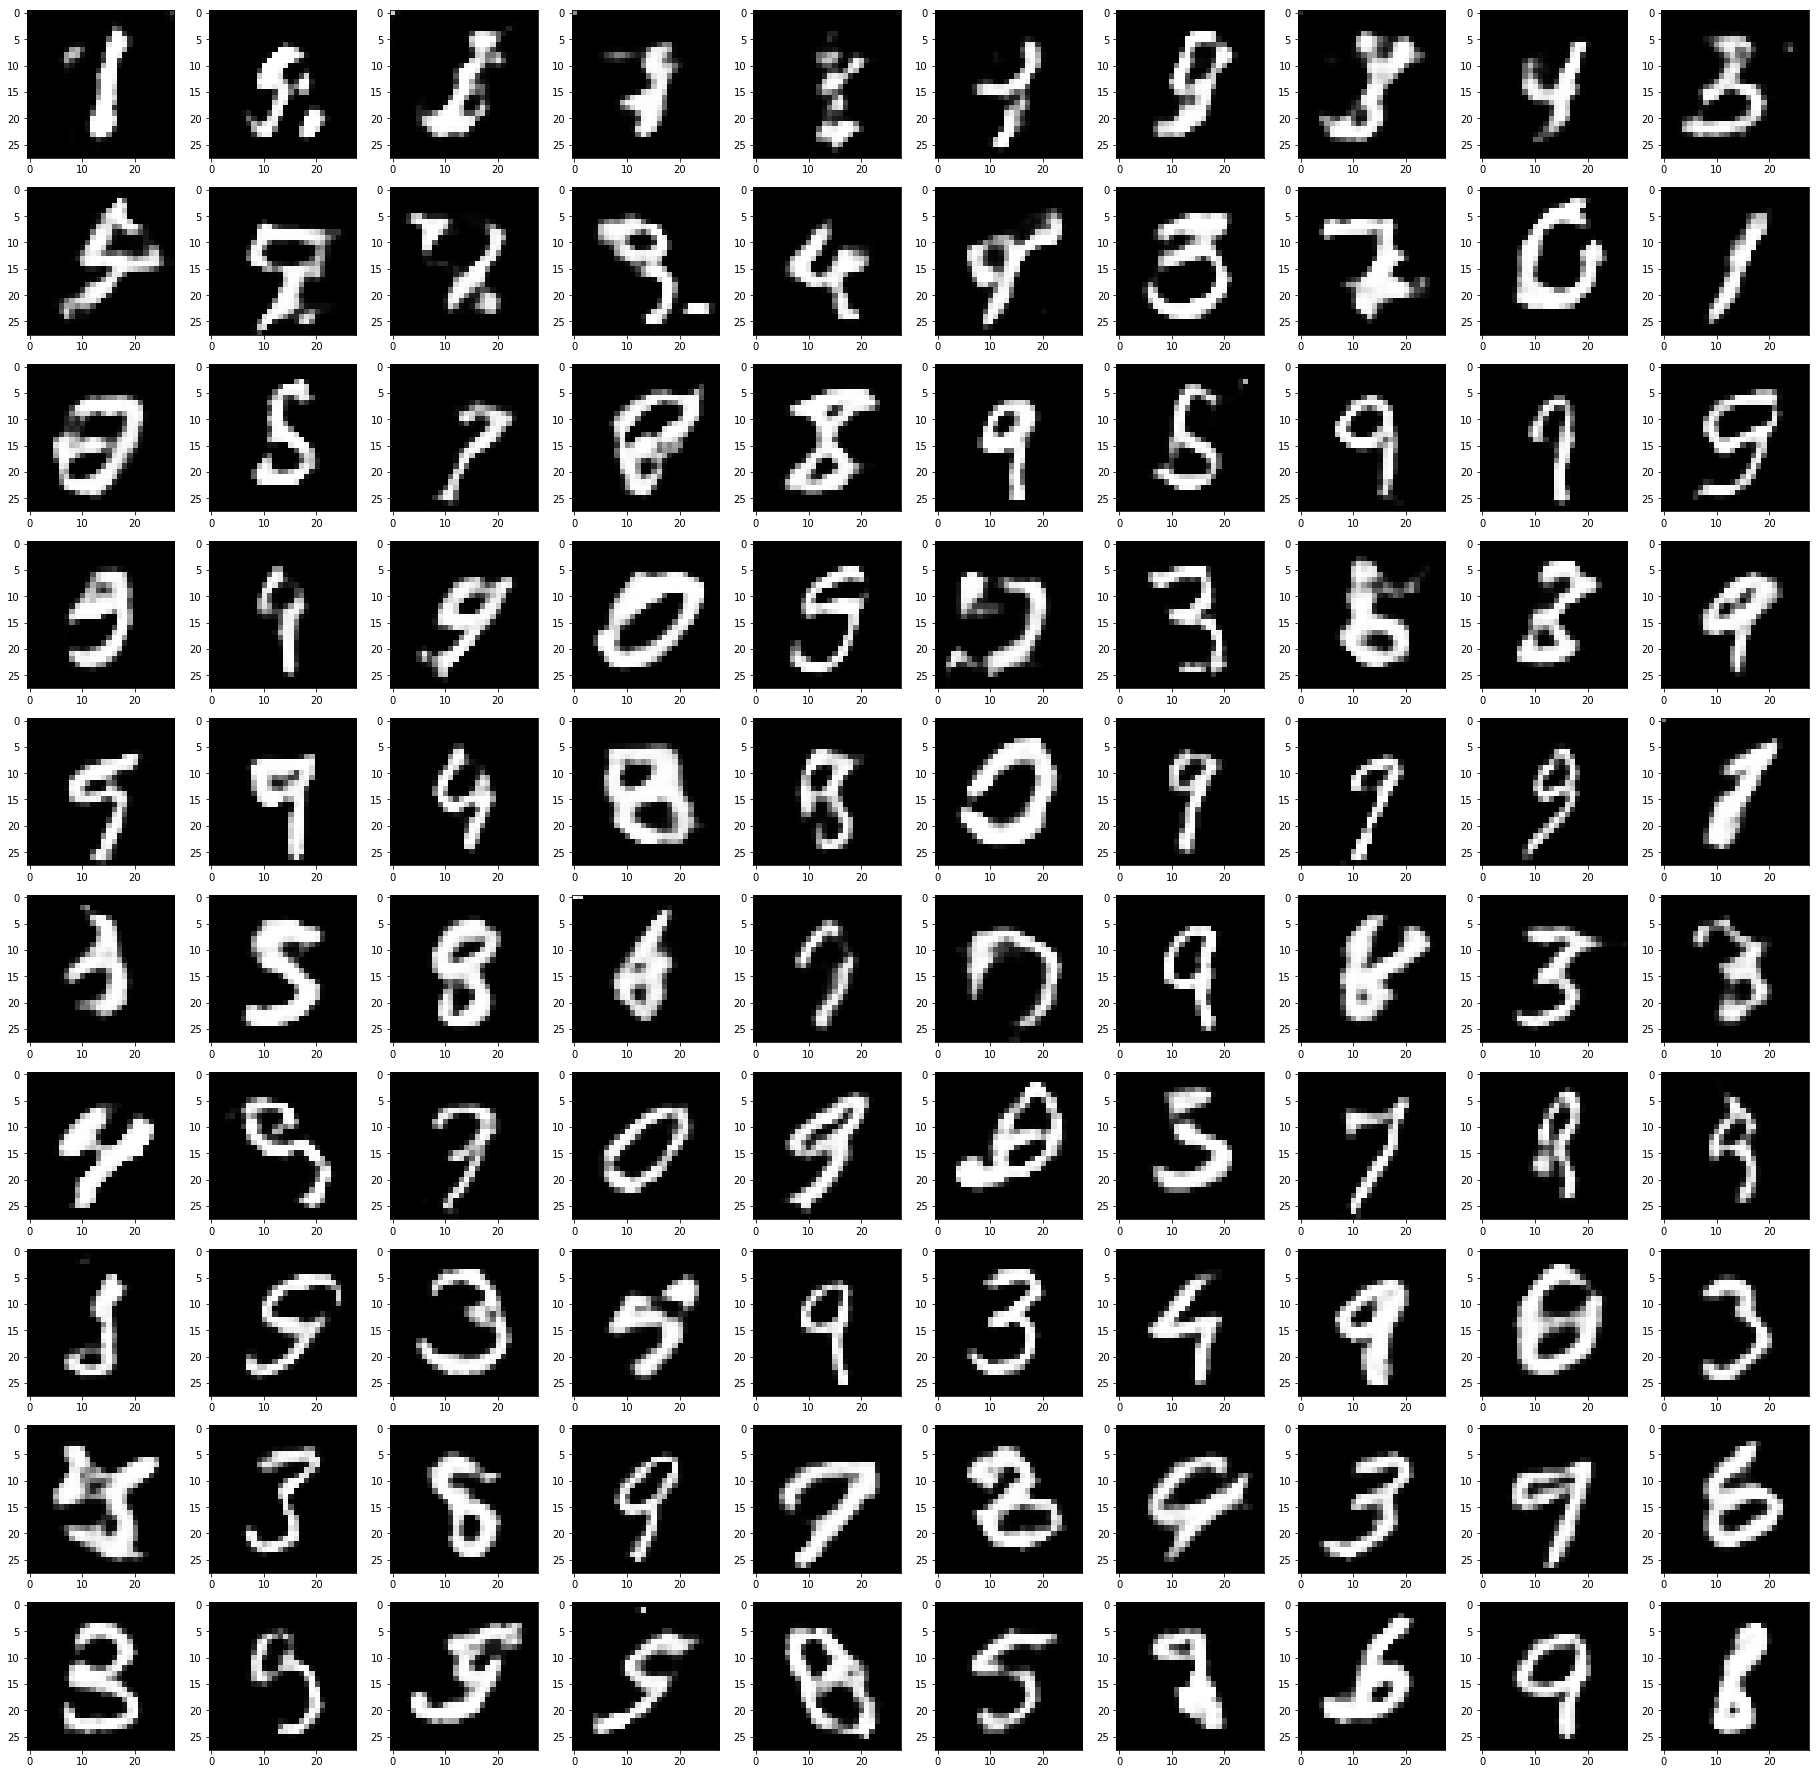

In [9]:
# Alright, everything's setup, let's run the GAN and train it first
print('Start training')
plt.figure(0, figsize = (32, 32))
for epoch in range(100):
    print('Epoch ', epoch + 1)
    pb = Progbar(x_train.size()[0])
    for i, (data, targets) in enumerate(train_loader, 0):
        ones = Variable(torch.ones(data.size()[0], 1)).cuda()
        zeros = Variable(torch.zeros(data.size()[0], 1)).cuda()

        data = Variable(data.float().cuda(async = True)) / 255

        # Train the discriminator
        # Max log(D(x)) + log(1 - D(G(z)))
        # Forward pass on real MNIST & Loss
        out_dis, _ = dis(data)
        loss_dis = torch.mean((out_dis - ones) ** 2)

        # Forward pass on generated MNIST & Loss
        out_gen = gen(Variable(torch.randn(data.size()[0], 128)).cuda())
        out_dis, _ = dis(out_gen.detach())
        loss_dis = loss_dis + torch.mean((out_dis - zeros) ** 2)

        dis.zero_grad()
        loss_dis.backward()
        d_optim.step()

        # Forward pass on generated MNIST & generator loss
        out_dis, _ = dis(out_gen)
        loss_gen = torch.mean((out_dis - ones) ** 2)

        gen.zero_grad()
        loss_gen.backward()
        g_optim.step()

        pb.update((i + 1) * data.size()[0],
                  [('loss_dis', loss_dis.cpu().data.numpy()), ('loss_gen', loss_gen.cpu().data.numpy())])

    pb.update(x_train.size()[0],
              [('loss_dis', loss_dis.cpu().data.numpy()), ('loss_gen', loss_gen.cpu().data.numpy())])

    print()
    plt.subplot(10, 10, epoch + 1)
    plt.imshow(np.round(out_gen.cpu().data.numpy()[0, 0] * 255), cmap = 'gray')

In [10]:
torch.save(gen.state_dict(), 'mnist_gen.torch')
torch.save(dis.state_dict(), 'mnist_dis.torch')

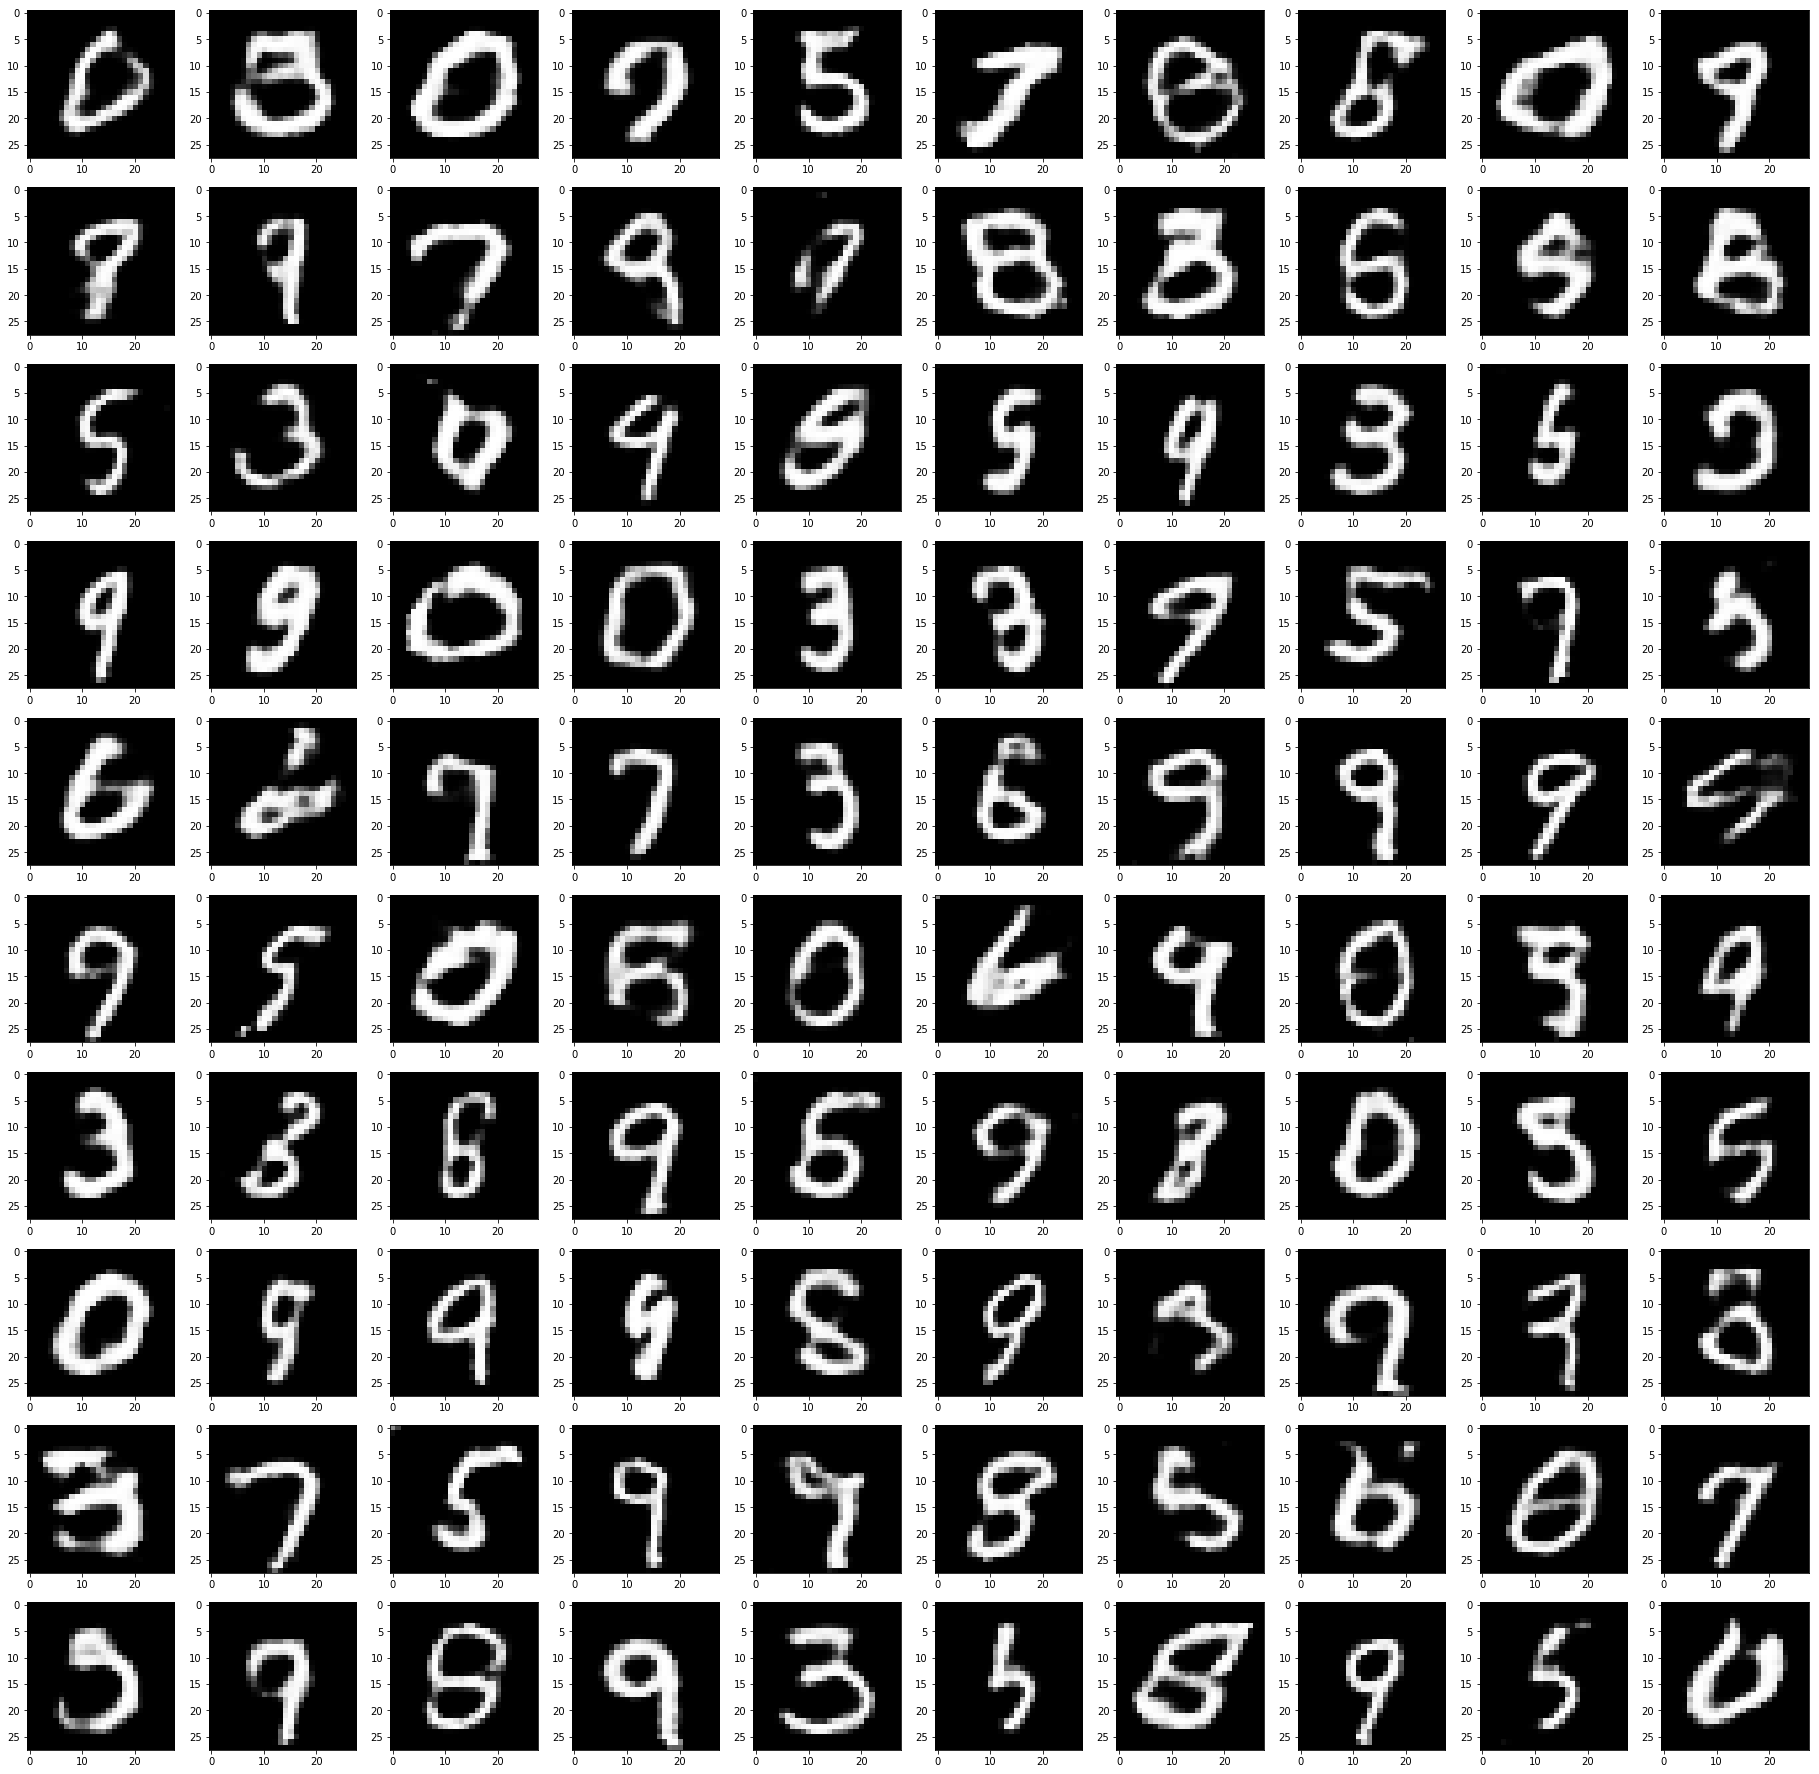

In [13]:
gen.load_state_dict(torch.load('mnist_gen.torch'))
dis.load_state_dict(torch.load('mnist_dis.torch'))

plt.figure(0, figsize = (32, 32))
out_gen = gen(Variable(torch.randn(100, 128)).cuda())
for i in range(10):
    for j in range(10):
        idx = i * 10 + j + 1
        plt.subplot(10, 10, idx)
        plt.imshow(np.round((out_gen[idx - 1, 0].cpu().data.numpy() + 1) * 127.5), cmap = 'gray')


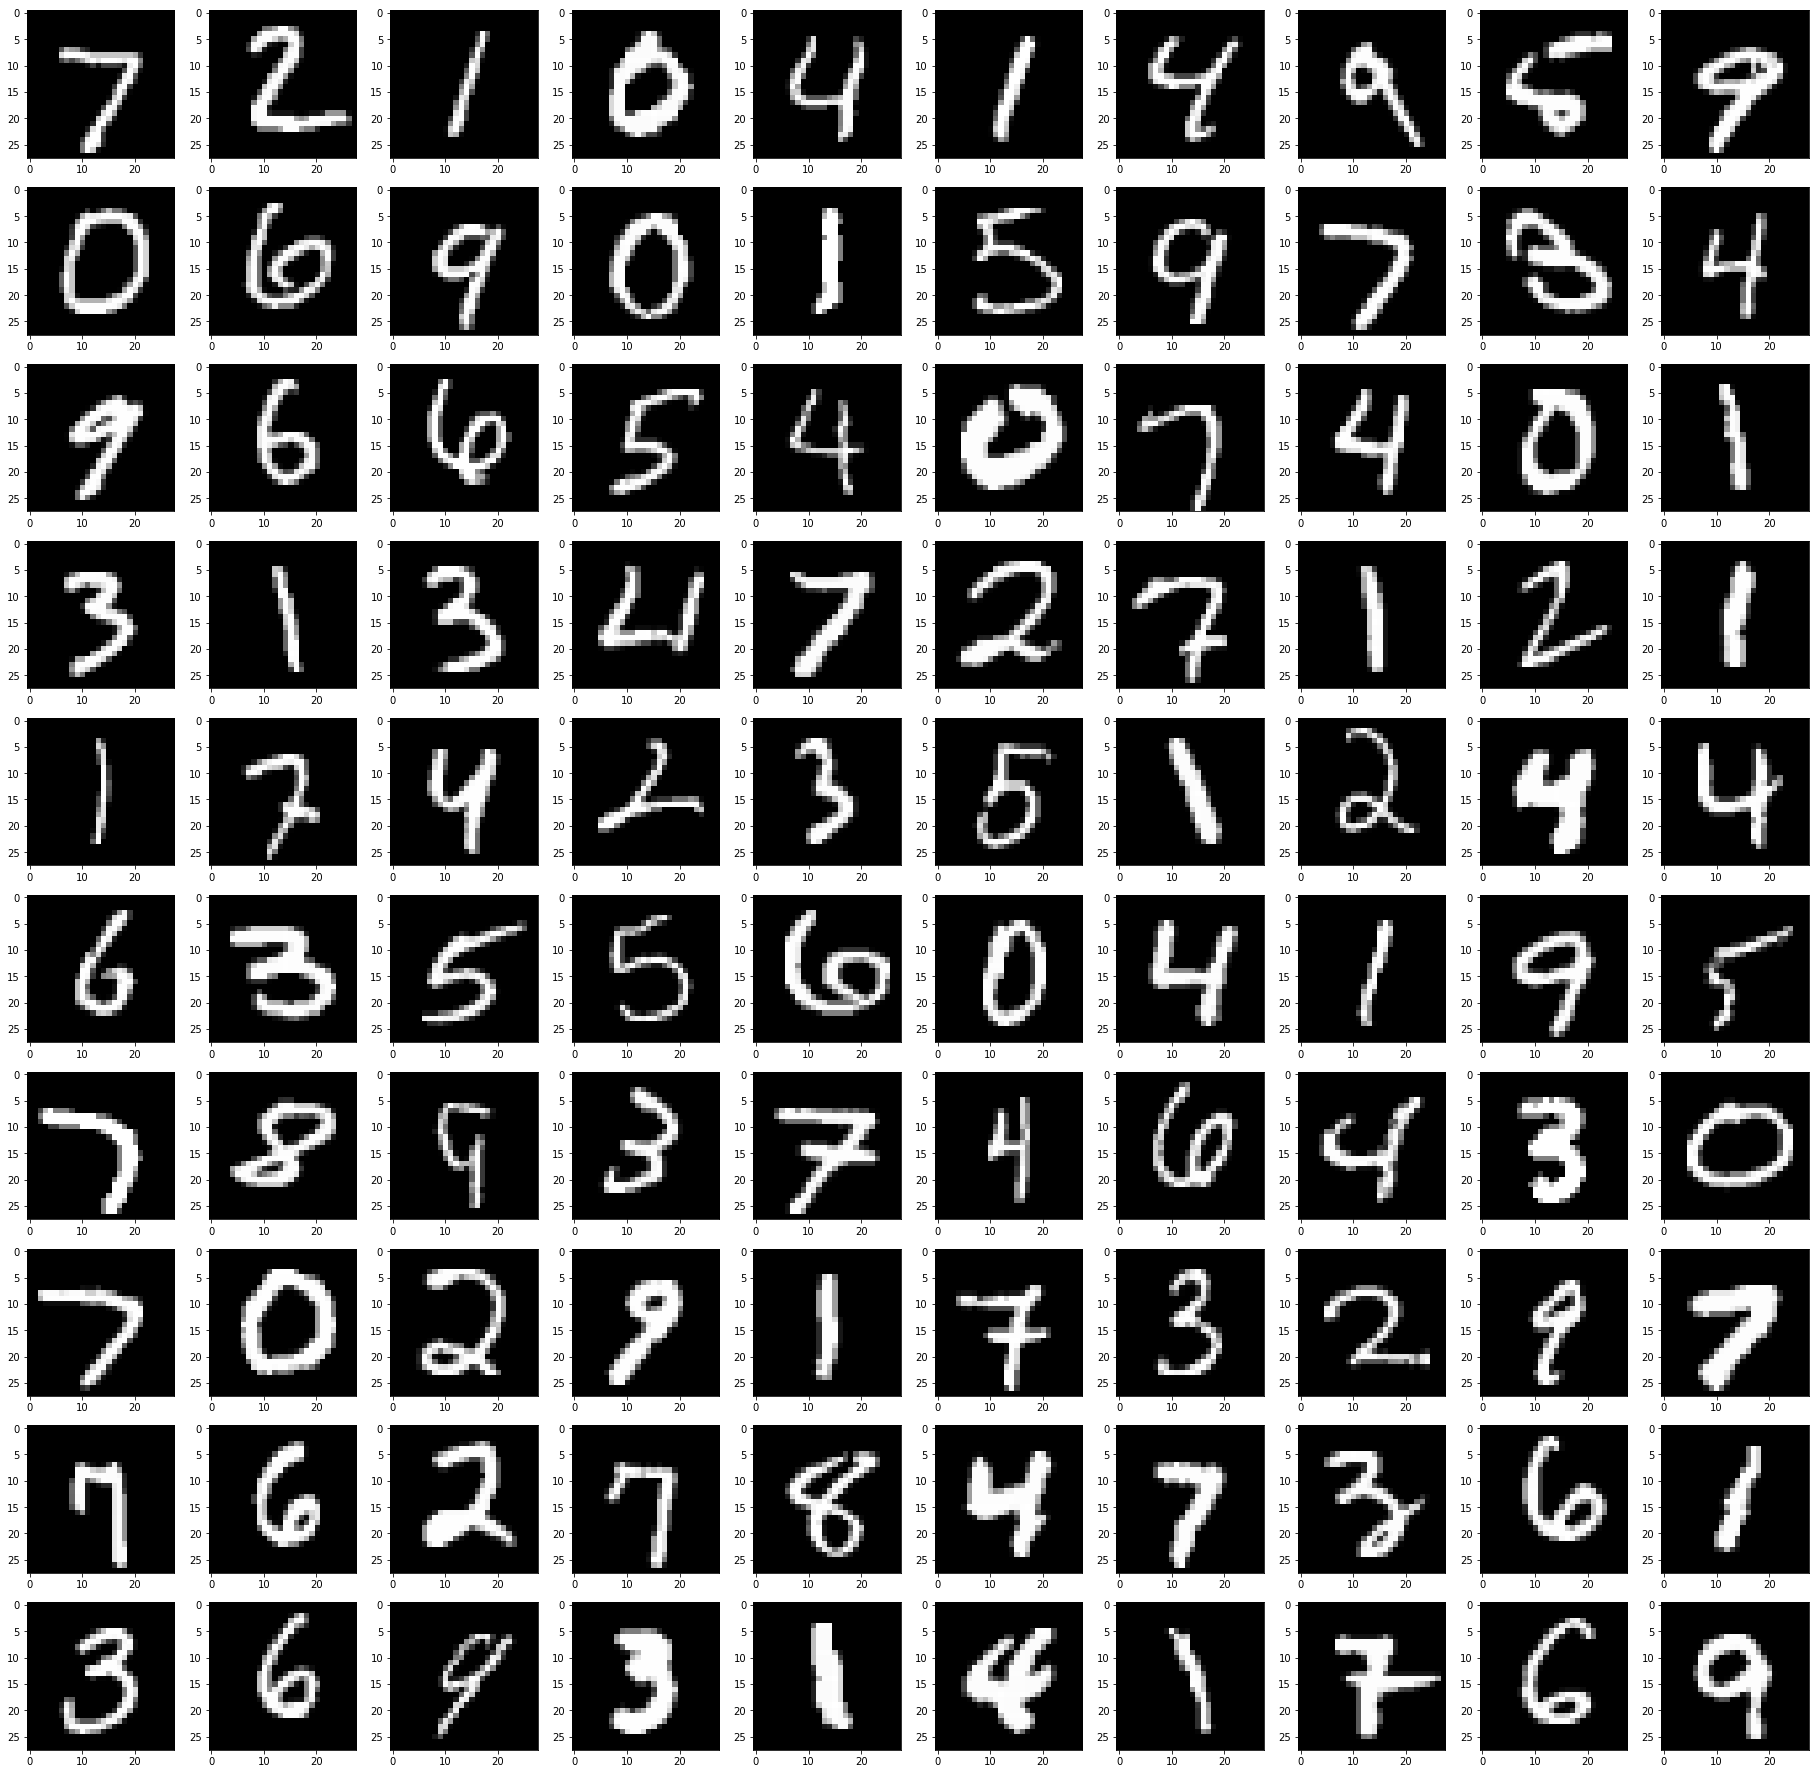

In [12]:
plt.figure(0, figsize = (32, 32))
for i in range(10):
    for j in range(10):
        idx = i * 10 + j + 1
        plt.subplot(10, 10, idx)
        plt.imshow(x_test[idx - 1, 0].cpu().numpy(), cmap = 'gray')